## ATLAS Open Data Initialisation

### To setup everytime
We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us handle complex and nested data structures efficiently
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* lmfit: tool for statistical fitting

In [1]:
import sys
import uproot # for reading .root files
import time # to measure time to analyse
import math # for mathematical functions such as square root
import awkward as ak # for handling complex and nested data structures efficiently
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
import lmfit # for the signal and background fits
import vector #to use vectors

import pyhf, json, cabinetry #likelihood model

## Example 1: Reading data

We will use the [atlasopenmagic](https://opendata.atlas.cern/docs/data/atlasopenmagic) to access the open data directly from the ATLAS OpenData Portal so no need to download any samples. First we import the module and load the Open Data release.

In [2]:
import atlasopenmagic as atom
atom.available_releases()
atom.set_release('2025e-13tev-beta')

Available releases:
2016e-8tev           2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev          2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp             2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi             2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta     2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen-13tev    2025 Open Data for research release for event generation at 13 TeV (https://opendata.cern.ch/record/160000).
2025r-evgen-13p6tev  2025 Open Data for research release for event generation at 13.6 TeV (https://opendata.cern.ch/record/160000).
Fetching and caching all metadata for release: 2025e-13tev-beta...
F

In [3]:
# Select the skim to use for the analysis
skim = "GamGam"

# Let's get the list of files to go through
# Notice that we use "cache" so that the files are downloaded locally and not streamed
files_list = atom.get_urls('data', skim, protocol='https', cache=True)

In [4]:
# Cut on the photon reconstruction quality
def cut_photon_reconstruction(photon_isTightID):
    # Only the events which have True for both photons are kept
    return (photon_isTightID[:,0]==True) & (photon_isTightID[:,1]==True)

# Cut on the transverse momentum
def cut_photon_pt(photon_pt):
# Only the events where photon_pt[0] > 50 GeV and photon_pt[1] > 30 GeV are kept
    return (photon_pt[:,0] > 50) & (photon_pt[:,1] > 30)

# Cut on the energy isolation
def cut_isolation_pt(photon_ptcone20, photon_pt):
# Only the events where the calorimeter isolation is less than 5.5% are kept
    return ((photon_ptcone20[:,0]/photon_pt[:,0]) < 0.055) & ((photon_ptcone20[:,1]/photon_pt[:,1]) < 0.055)

# Cut on the pseudorapidity in barrel/end-cap transition region
def cut_photon_eta_transition(photon_eta):
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
    condition_0 = (np.abs(photon_eta[:, 0]) < 1.52) | (np.abs(photon_eta[:, 0]) > 1.37)
    condition_1 = (np.abs(photon_eta[:, 1]) < 1.52) | (np.abs(photon_eta[:, 1]) > 1.37)
    return condition_0 & condition_1

# This function calculates the invariant mass of the 2-photon state
def calc_mass(photon_pt, photon_eta, photon_phi, photon_e):
    p4 = vector.zip({"pt": photon_pt, "eta": photon_eta, "phi": photon_phi, "e": photon_e})
    invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
    return invariant_mass

# Cut on null diphoton invariant mass
def cut_mass(invariant_mass):
    return (invariant_mass != 0)

# Cut on the pT relative to the invariant mass
# Only the events where the invididual photon pT is larger than 35% of the invariant mass are kept
def cut_iso_mass(photon_pt, invariant_mass):
    return ((photon_pt[:,0]/invariant_mass) > 0.35) & ((photon_pt[:,1]/invariant_mass) > 0.35)

## Final Analysis

For the final analysis, we'll begin by applying the cuts and calculating the invariant masses across all the data. Once that's done, we'll fit the data to uncover the Higgs boson peak. Let's kick things off by applying the cuts and calculating those invariant masses!

In [5]:
# Controls the fraction of all the events analysed. All of the data is used by
# default to run this analysis (implemented in the loop over the tree). Reduce
# this if you want the code to run quicker. This can take several minutes to
# process the entire dataset
fraction = 1.0
# Holder for the masses as we process the files
sample_data = []
variables = ["photon_pt","photon_eta","photon_phi","photon_e","photon_isTightID","photon_ptcone20"]

# Loop over all the files in our list
for afile in files_list:

    # Print which sample is being processed
    print(f'Processing file {afile} ({files_list.index(afile)}/{len(files_list)})')

    # Open file
    tree = uproot.open(afile + ":analysis")

    numevents = tree.num_entries

    # Perform the cuts for each data entry in the tree and calculate the invariant mass
    for data in tree.iterate(variables, library="ak", entry_stop=int(numevents*fraction)):

        photon_isTightID = data['photon_isTightID']
        data = data[cut_photon_reconstruction(photon_isTightID)]

        photon_pt = data['photon_pt']
        data = data[cut_photon_pt(photon_pt)]

        data = data[cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

        photon_eta = data['photon_eta']
        data = data[cut_photon_eta_transition(photon_eta)]

        data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])

        data = data[cut_mass(data['mass'])]

        data = data[cut_iso_mass(data['photon_pt'], data['mass'])]

        # Append data to the whole sample data list
        sample_data.append(data['mass'])
        
# turns sample_data back into an awkward array
all_data = ak.concatenate(sample_data)

Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root (0/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodE.GamGam.root (1/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodF.GamGam.root (2/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodG.GamGam.root (3/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodH.GamGam.root (4/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodJ.GamGam.root (5/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data16_periodA.GamG

We are now ready to fit our data to effectively detect the Higgs boson! We will use a combination of a 4th order polynomial and a Gaussian function. The polynomial function represents the background, while the Gaussian function represents our signal. The Gaussian model is used to fit the signal due to the nature of the detector's resolution. The fourth-order polynomial is chosen for the background because it offers enough flexibility to capture the overall shape without overfitting, thereby reducing the influence of spurious data—random, irrelevant fluctuations or noise that do not correspond to the true signal or background.

[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 156
    # data points      = 60
    # variables        = 7
    chi-square         = 54.0769409
    reduced chi-square = 1.02031964
    Akaike info crit   = 7.76379808
    Bayesian info crit = 22.4242100
    R-squared          = 0.99882953
[[Variables]]
    c0:         18109.6982 +/- 4683.03650 (25.86%) (init = 8269.506)
    c1:         25.7466745 +/- 108.025608 (419.57%) (init = 251.4802)
    c2:        -2.06702098 +/- 0.82233876 (39.78%) (init = -3.768142)
    c3:         0.00789810 +/- 0.00206770 (26.18%) (init = 0.01211949)
    amplitude:  797.026849 +/- 195.917849 (24.58%) (init = 100)
    center:     124.689281 +/- 0.27547637 (0.22%) (init = 125)
    sigma:      1.12680866 +/- 0.28967798 (25.71%) (init = 2)
    fwhm:       2.65343157 +/- 0.68213950 (25.71%) == '2.3548200*sigma'
    height:     282.184310 +/- 61.4119033 (21.76%) == '0.3989423*amplitude/ma

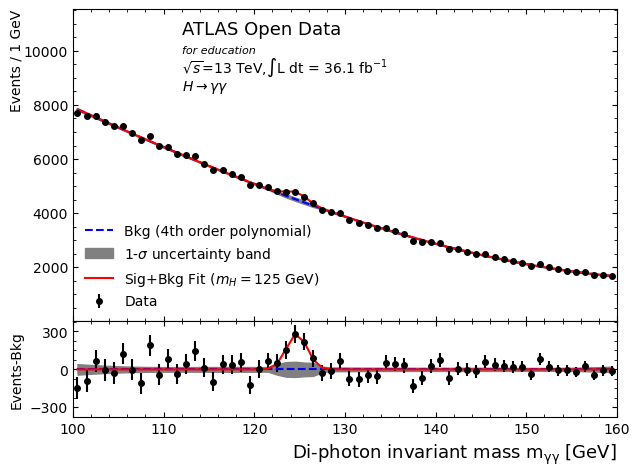

In [7]:
#Bin edges
xmin = 100 #GeV
xmax = 160 #GeV
step_size = 1 #GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

#Set the data
partial_data =all_data[::1]
data_x,_ = np.histogram(ak.to_numpy(partial_data), bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

# data fit
Degree=3
polynomial_mod = lmfit.models.PolynomialModel( Degree ) # 4th order polynomial
gaussian_mod = lmfit.models.GaussianModel() # Gaussian

# set initial guesses for the parameters of the polynomial model
pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                            x=bin_centres)
#for par in pars: pars[par].set(value=1)
        
# set initial guesses and ranges for the parameters of the Gaussian model
pars += gaussian_mod.make_params(center=125,
                   amplitude=dict(value=100, min=0, max=1e6),
                   sigma=dict(value=2, min=0, max=5))

model = polynomial_mod + gaussian_mod # combined model

# fit the model to the data
result = model.fit(data_x, # data to be fit
                pars, # guesses for the parameters
                x=bin_centres, weights=1/data_x_errors ) 
print(result.fit_report())

# background part of fit
params_dict = result.params # get the parameters from the fit to data
#for par in params_dict: print(f"{par},\t{params_dict[par].value},\t{params_dict[par].stderr}")
background_x=polynomial_mod.eval(params=params_dict,x=bin_centres)

# data fit - background fit = signal fit
signal_x = data_x - background_x

# *************
# Main plot
# *************
plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data', markersize=4) # black circles

# plot the background only fit
main_axes.plot(bin_centres, background_x, '--b', label='Bkg (4th order polynomial)') # dashed blue line

# dely0 = result.eval_uncertainty(sigma=1,params=params_dict)
# print(dely0)
# from copy import deepcopy
# params_dict_bkg=deepcopy(params_dict)
# #for par in params_dict.keys():
# #    if par=="amplitude" or par=="center" or par=="sigma":
# #        params_dict_bkg.set(vary=False)
# #        print(par)
# for name in params_dict_bkg: params_dict_bkg[name].vary = (name not in ["amplitude", "center", "sigma","fwhm","height"])   
# for name in params_dict_bkg:
#     print(name,params_dict_bkg[name],params_dict_bkg[name].vary)
# print(params_dict_bkg)
# dely = result.eval_uncertainty(sigma=1,params=params_dict_bkg)
# print(dely-dely0)

dely = result.eval_uncertainty(sigma=1)
plt.fill_between(bin_centres, background_x-dely, background_x+dely, color="gray", label=r'1-$\sigma$ uncertainty band')

# plot the signal + background fit
main_axes.plot(bin_centres, result.best_fit,'-r', label='Sig+Bkg Fit ($m_H=125$ GeV)') # single red line

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax )

# separation of x-axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() )

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                    direction='in', # Put ticks inside and outside the axes
                    top=True, # draw ticks on the top axis
                    labelbottom=False, # don't draw tick labels on bottom axis
                    right=True ) # draw ticks on right axis

# write y-axis label for main
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                    horizontalalignment='right')

# set the y-axis limit for the main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5 )

# set minor ticks on the y-axis of the main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() )

# avoid displaying y=0 on the main axes
main_axes.yaxis.get_major_ticks()[0].set_visible(False)

# Add text 'ATLAS Open Data' on plot
plt.text(0.2, 0.92, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13 )

# Add text 'for education' on plot
plt.text(0.2, 0.86, 'for education', transform=main_axes.transAxes, style='italic',fontsize=8 )

lumi = 36.1
lumi_used = str(lumi*fraction) 
plt.text(0.2, 0.8, r'$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', transform=main_axes.transAxes ) 

# Add a label for the analysis carried out
plt.text(0.2, 0.74, r'$H \rightarrow \gamma\gamma$', transform=main_axes.transAxes ) 

# draw the legend
main_axes.legend(frameon=False, # no box around the legend
                loc='lower left' ) # legend location

# *************
# Data-Bkg plot
# *************
plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
sub_axes = plt.gca() # get the current axes

# set the y axis to be symmetric about Data-Background=0
sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', symmetric=True) )

# plot Data-Background
sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors, fmt='ko',markersize=4 ) # black circles

# draw the background only fit
sub_axes.plot(bin_centres, background_x-background_x, '--b' )  # dashed blue line

# draw the fit to data
sub_axes.plot(bin_centres, result.best_fit-background_x, '-r' ) # single red line

plt.fill_between(bin_centres, -dely, dely, color="gray", label=r'1-$\sigma$ uncertainty band')

# set the x-axis limits on the sub axes
sub_axes.set_xlim( left=xmin, right=xmax )

# separation of x-axis minor ticks
sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )

# x-axis label
sub_axes.set_xlabel(r'Di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]', x=1, horizontalalignment='right',fontsize=13 )

# set the tick parameters for the sub axes
sub_axes.tick_params(which='both', direction='in', top=True, right=True ) 

# separation of y-axis minor ticks
sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )

# y-axis label on the sub axes
sub_axes.set_ylabel( 'Events-Bkg' )

# Generic features for both plots
main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

In [13]:
signal_x[signal_x < 0] = 0
#dely=dely*10

model_spec = {
    "channels": [
        {
            "name": "channel",
            "samples": [
                {
                    "name": "signal",
                    "data": signal_x.tolist(),
                    "modifiers": [
                        {"name": "mu", "type": "normfactor", "data":None}  # parameter of interest
                    ]
                },
                {
                    "name": "background",
                    "data": background_x.tolist(),
                    "modifiers": [
                        {"name": "bkg_uncert", "type": "shapesys", "data": dely.tolist()}
                    ]
                }
            ]
        }
    ]
}
# Build the model
# model = pyhf.Model(model_spec)
## data = np.concatenate([data_x, model.config.auxdata])
# data = data_x.tolist()+model.config.auxdata

#The observed data must be given as a named observation in the channel
workspace_spec = {
    "version": "1.0.0",
    "channels": model_spec["channels"],
    "observations": [
        {"name": "channel", "data": data_x.tolist()}
    ],
    "measurements": [
        {
            "name": "measurement",
            "config": {
                "poi": "mu",
                "parameters": []
            }
        }
    ]
}

# Create the workspace object
ws = pyhf.Workspace(workspace_spec)
model = ws.model()       # same as before, created from workspace
data = ws.data(model)   # observed data + auxdata automatically assembled

print(f"  POI name:   {model.config.poi_name}")
print(f"  channels:   {model.config.channels}")
print(f"     nbins:   {model.config.channel_nbins}")
print(f"   samples:   {model.config.samples}")
print(f" modifiers:   {model.config.modifiers}")
print(f"N paramaters: {model.config.npars}")
print(f"parameters:   {model.config.parameters}")
print(f"  nauxdata:   {model.config.nauxdata}")
#print(f"   auxdata:   {model.config.auxdata}")

  POI name:   mu
  channels:   ['channel']
     nbins:   {'channel': 60}
   samples:   ['background', 'signal']
 modifiers:   [('bkg_uncert', 'shapesys'), ('mu', 'normfactor')]
N paramaters: 61
parameters:   ['bkg_uncert', 'mu']
  nauxdata:   60


In [15]:
bestfit = pyhf.infer.mle.fit(data, model)
mu_hat = bestfit[model.config.poi_index]
print("Best-fit μ:", mu_hat)

Best-fit μ: 1.0030015296845378


In [16]:
CLs = pyhf.infer.hypotest(1.0, data, model, test_stat="qtilde")
print("CLs:", CLs)

CLs: 0.5092212215273969


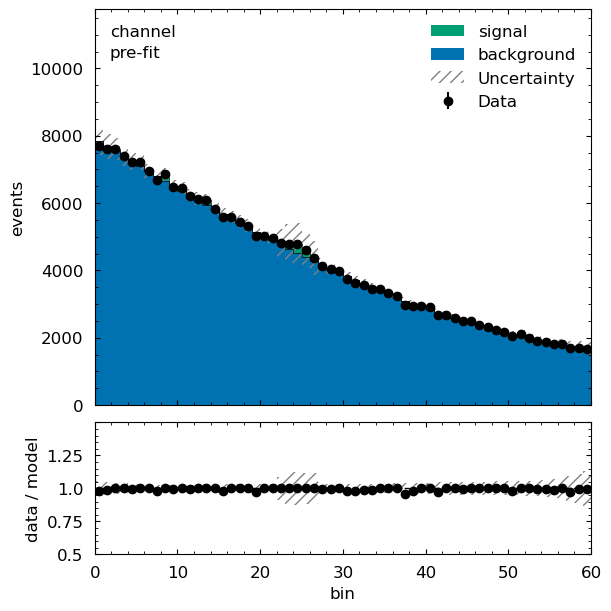

In [17]:
model_prefit = cabinetry.model_utils.prediction(model)
_ = cabinetry.tabulate.yields(model_prefit, data)
_ = cabinetry.visualize.data_mc(model_prefit, data)

In [19]:
significance_results = cabinetry.fit.significance(model, data)
print(significance_results)

SignificanceResults(observed_p_value=0.01841101820850586, observed_significance=np.float64(2.087731779987928), expected_p_value=0.018411018495925226, expected_significance=np.float64(2.087731773618959))
